<a href="https://colab.research.google.com/github/badrinarayanan02/machine_learning/blob/main/2348507_lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You are a data scientist tasked with developing a machine learning model to classify brain MRI
images as either having a tumor or not. You have been provided with the &quot;Brain Tumor
Classification (MRI)&quot; dataset from Kaggle, which contains MRI images along with labels
indicating the presence or absence of tumors. Your goal is to build, train, and evaluate an SVM-
based classification model for this medical imaging task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration and Visualization

In [4]:
import os
import cv2

path = '/content/drive/MyDrive/Training'
classes = {'no_tumor': 0, 'pituitary_tumor': 1}
X = []
Y = []

for cls in classes:
    pth = os.path.join(path, cls)
    for j in os.listdir(pth):
        img = cv2.imread(os.path.join(pth, j), 0)
        img = cv2.resize(img, (200, 200))
        X.append(img)
        Y.append(classes[cls])

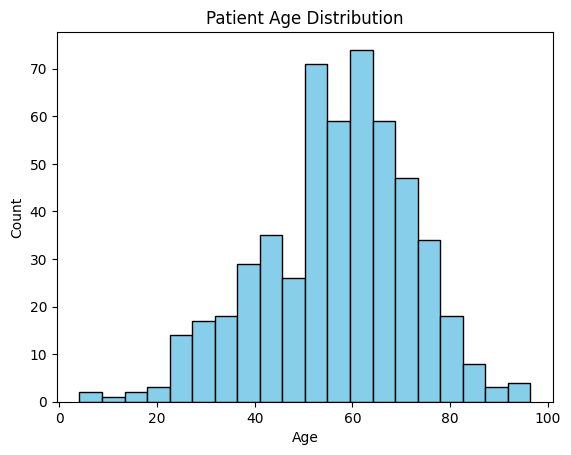

In [5]:
from sklearn.mixture import GaussianMixture

num_samples_per_class = [Y.count(0), Y.count(1)]

gmm_params = [{'mean': 50, 'std_dev': 15, 'weight': 0.7},  # Parameters for 'no_tumor' class
              {'mean': 65, 'std_dev': 10, 'weight': 0.3}]   # Parameters for 'pituitary_tumor' class

patient_ages = []
for i, params in enumerate(gmm_params):

    ages = np.random.normal(params['mean'], params['std_dev'], int(params['weight'] * num_samples_per_class[i]))
    patient_ages.extend(ages)

plt.hist(patient_ages, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Patient Age Distribution')
plt.show()

# Data Preprocessing

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set - X:", len(X_train), " Y:", len(Y_train))
print("Testing set - X:", len(X_test), " Y:", len(Y_test))

Training set - X: 977  Y: 977
Testing set - X: 245  Y: 245


Apply data augmentation techniques to increase the size of the training dataset. Visualize
some augmented images.

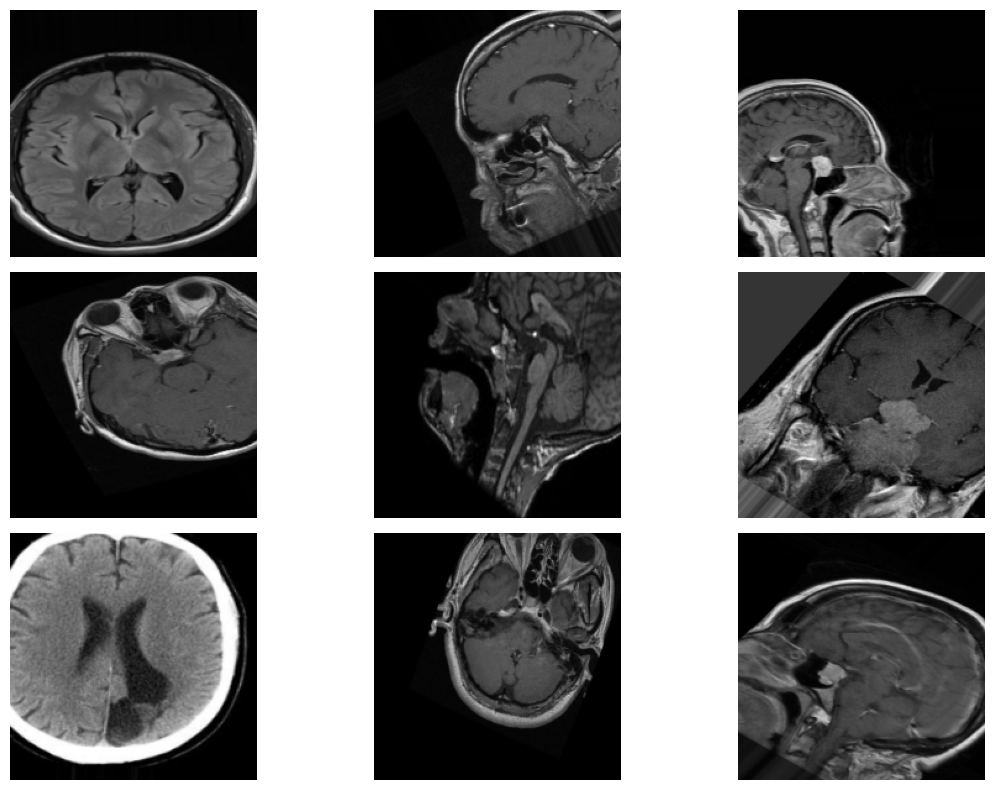

In [8]:
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train_reshaped = np.array(X_train).reshape(-1, 200, 200, 1)

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


plt.figure(figsize=(12, 8))
for i in range(9):
    augmented_img, _ = datagen.flow(np.array([X_train_reshaped[i]]), np.array([Y_train[i]]), batch_size=1).next()
    augmented_img = augmented_img.squeeze()  # Remove the channel dimension

    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_img.astype('uint8'), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model Building and Training

Extract relevant features from the MRI images. Visualize a few examples of these extracted
features.

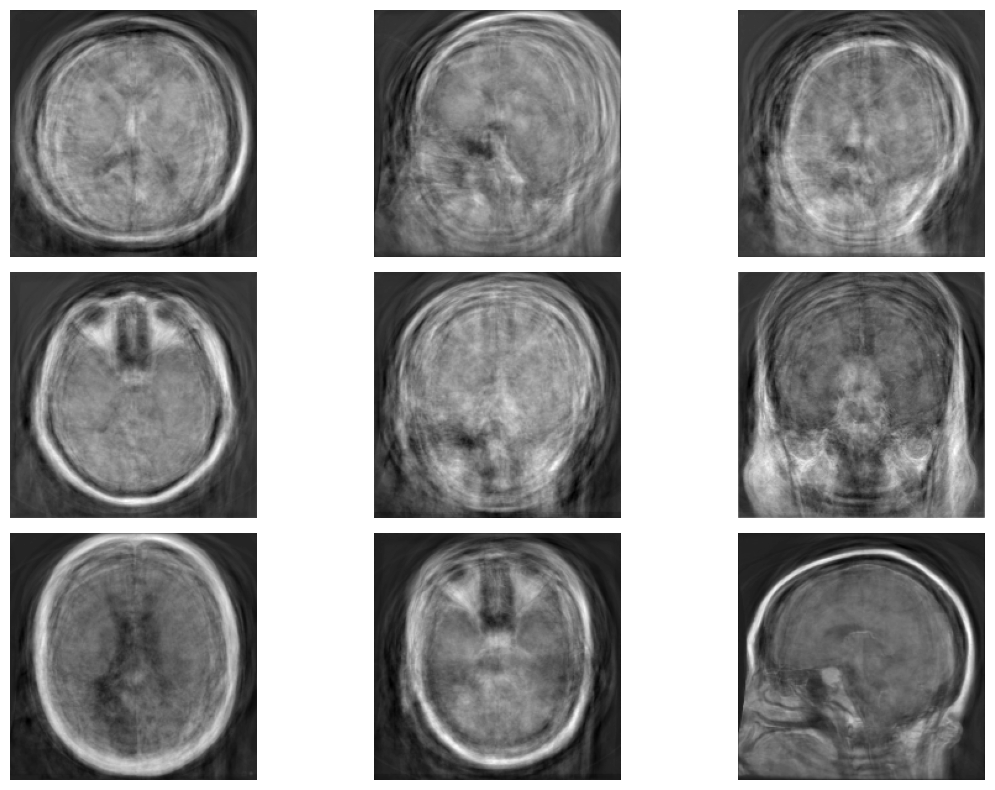

In [9]:
from sklearn.decomposition import PCA

X_train_reshaped = np.array(X_train).reshape(-1, 200 * 200)

n_components = 100
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_reshaped)

# Visualizing a few examples of the extracted features

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    feature_image = pca.inverse_transform(X_train_pca[i]).reshape(200, 200)
    plt.imshow(feature_image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

Train an SVM classifier on the training data. Visualize the decision boundary of the SVM
classifier along with support vectors.

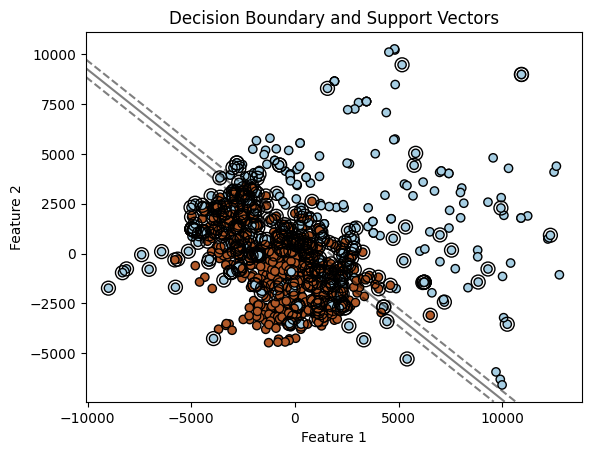

In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_train_reshaped = np.array(X_train).reshape(-1, 200 * 200)


svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0))
])
svm_clf.fit(X_train_reshaped, Y_train)

# Function to plot decision boundary and support vectors

def plot_decision_boundary(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()


    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)


    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])


    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary and Support Vectors')
    plt.show()

# Extract two principal components for visualization

pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train_reshaped)

svm_clf_2d = SVC(kernel='linear', C=1.0)
svm_clf_2d.fit(X_train_2d, Y_train)

plot_decision_boundary(X_train_2d, Y_train, svm_clf_2d)


# Model Evaluation

Evaluate the SVM model&#39;s performance using metrics like accuracy, precision, recall, F1-
score, and ROC-AUC. Visualize the confusion matrix.

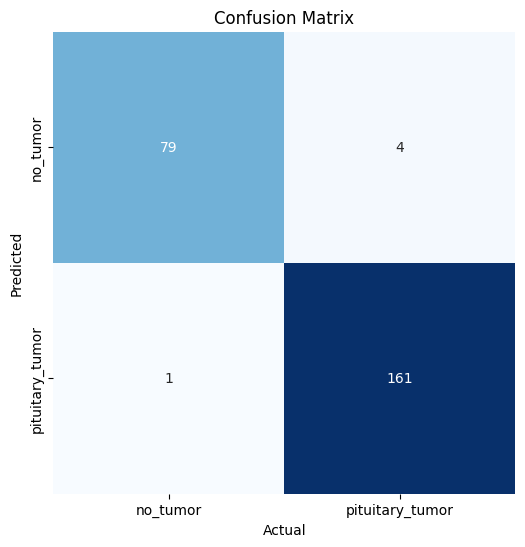

Accuracy: 0.9795918367346939
Precision: 0.9757575757575757
Recall: 0.9938271604938271
F1 Score: 0.9847094801223242
ROC AUC Score: 0.9728171947047448


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

X_test_reshaped = np.array(X_test).reshape(-1, 200 * 200)

Y_pred = svm_clf.predict(X_test_reshaped)

accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)


fpr, tpr, _ = roc_curve(Y_test, Y_pred)

# Visualizing the confusion matrix

conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=['no_tumor', 'pituitary_tumor'], yticklabels=['no_tumor', 'pituitary_tumor'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Displaying the metrics

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)


Plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the
Curve (AUC) to assess the model&#39;s discrimination ability.

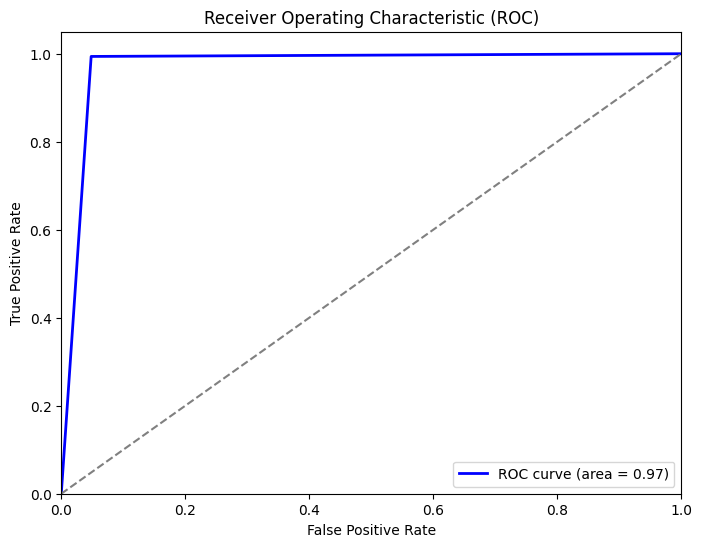

Area Under the Curve (AUC): 0.9728171947047448


In [12]:
import matplotlib.pyplot as plt

# Plotting the ROC curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Area Under the Curve (AUC):", roc_auc)


# Hyperparameter Tuning

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


param_dist = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'degree': randint(2, 5)
}

# Perform RandomizedSearchCV to find the best hyperparameters

random_search = RandomizedSearchCV(SVC(), param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train_reshaped, Y_train)

random_results = random_search.cv_results_
best_params_random = random_search.best_params_
best_estimator_random = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters (RandomizedSearchCV):", best_params_random)

Best Hyperparameters (RandomizedSearchCV): {'C': 10, 'degree': 2, 'kernel': 'rbf'}
